# Decluttering


### Purpose

This notebook attempts to find potential clutter in the organisation, and send a gentle reminder to the item owners to consider removing the items. 

### Introduction

A good sign of a healthy ArcGIS System is the velocity of new items being created and shared amongst the users.  And creating collaborative content is something that should be encouraged.  However, a knock-on effect with this is that your ArcGIS System can start to accumulate older content that may no longer be useful to the organisation.  

It can be a good idea to run scheduled stocktakes to ensure the content is still being used and relevant. 

Some people hoarde.  They like to accumulate items regardless of if they still have any value or use within the greater organisation.  As long as this content is shared appropriately (i.e. kept private to the user), then this is not a huge issue.  However, content uses storage and this can lead to either credits or infrastructure costs.

Some hoarders (myself included) may just be unaware of the items they have accumulated and are no longer being used.  

As an ArcGIS System owner, it is considerate to not force decluttering your users content.  But a polite nudge might be all that is needed to challenge the item owners to consider removing their items.

As an ArcGIS System owner, this notebook will help you filter down your organisations content to report on the clutter, and allow you to notify the item owners about this content.  

The notebook can be run ad-hoc or scheduled to run, perhaps once a month.

## Finding the Content

#### Connect to GIS
The Principle of Least Privilege requires that this Notebook should connect to the GIS with the following admin privilege(s):

- Allow member to view all content within your organization.

Running a notebook with full admin privileges is high risk, especially if you start to modify the notebook.  Copy this notebook into an ArcGIS Developer Plan to customise and familiarise yourself before running against a production system.


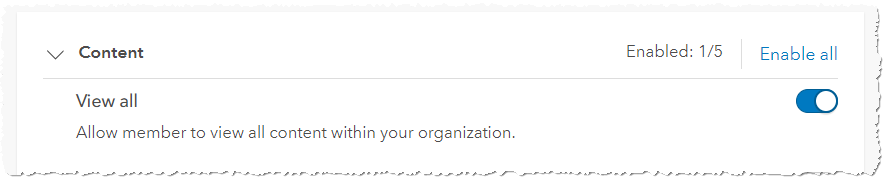

In [1]:
from arcgis.gis import GIS
gis = GIS("home", expiration=9999)

#### Set your thresholds

Defining clutter will have mixed opinions. To attempt to quantify it, we can use three variables:

1. Has this item had any significant usage recently?

2. How much disk space does this item take up?

3. How old is the item?

In [ ]:
# ── Configuration ────────────────────────────────────────────────────────────
# Edit the values in this cell before running anything else.

# STALE ITEM THRESHOLDS
# An item must meet ALL THREE conditions below to be considered stale.
views    = 10   # fewer than this many views in the last 60 days
size_mb  = 5    # larger than this many MB
age_days = 40   # older than this many days

# HOSTED TABLE
# The ArcGIS Online item ID of the table used to store the clutter report.
# See the README for the table template link.
table_item = '360d491480684a6da51ecee57ab166a7'  # replace with your item ID

# NOTIFICATION SETTINGS
# The prefix written to item comments so the notebook can detect prior runs.
# WARNING: do not change this after the first run — changing it will cause
# already-notified items to be treated as new and notified again.
NOTIFICATION_PREFIX = '⚠️ AUTOMATED NOTIFICATION'

# How long to wait between posting each comment (seconds).
# ArcGIS Online rate-limits comment posting — do not set below 12.
SLEEP_BETWEEN_COMMENTS = 15

#### Find the Clutter

Filter to just the hosted feature item types, as these use up the most credits.

This can be removed from filter if you want to search across all items.

For testing you can also add a *query="owner:user"* to just look at an individuals content.

Should use a query to filter out items older than *age_days*, but encountered an issue, so filtering these out a few cells later.

In [3]:
# Search for all Hosted Feature Services in the organisation.
# Note: content.search() is capped at max_items=9999.  If your org has more
# than ~10 000 items, switch to gis.content.advanced_search() instead.
all_items = gis.content.search(
    query="*",
    sort_field="modified",
    sort_order="desc",
    item_type="Feature Service",
    max_items=9999,
)
print(f"Feature Services found: {len(all_items)}")


c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'esriau.maps.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'esriau.maps.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'esriau.maps.arcgis.com'. Adding certificate verification is strongly advised. See: https://url

Feature Services found: 7374


The following cell:

- Iterates through the items from above query
- Filter list to large items (threshold set by *size_mb*)
- Fetch the usage data on each item (# views in last 60 days)
- Filter list to low usage items (threshold set in *views*)
- Get some reporting metrics for each item
- Get additional reporting metrics from the item.owner

This cell can take awhile to run, depending on how many items you have in your organisation.

Some items it can have issue with.  This includes table services and feature servcices from other unfederated sites/orgs.

In [4]:
from datetime import datetime, timezone
from tqdm.notebook import tqdm

f_item = []
now = datetime.now(timezone.utc)  # timezone-aware; avoids deprecated utcnow()

with tqdm(total=len(all_items), desc='Scanning items') as pbar:
    for i in all_items:
        pbar.update(1)

        # --- Age filter ---
        # i.created is a Unix timestamp in milliseconds
        i_created = datetime.fromtimestamp(i.created / 1000, tz=timezone.utc)
        if (now - i_created).days < age_days:
            continue  # item is too new to be considered stale

        # --- Size filter (decimal MB, consistent with table write below) ---
        size_mb_val = i.size / 1_000_000
        if size_mb_val <= size_mb:
            continue

        # --- Usage filter ---
        try:
            df_u = i.usage('60D', as_df=True)
            total_usage_60d = int(df_u['Usage'].sum())
        except Exception as e:
            # FIX: original bare except fell through to 'if total_usage_60d < views'
            # with total_usage_60d potentially undefined.  We now skip explicitly.
            print(f"  ⚠ Could not fetch usage for '{i.title}' — skipping. ({e})")
            continue

        if total_usage_60d >= views:
            continue  # item has sufficient recent usage

        # --- Collect attributes ---
        f = {
            "attributes": {
                "title":             i["title"],
                "id":                i["id"],
                "owner":             i["owner"],
                "created":           i["created"],
                "modified":          i["modified"],
                "type":              i["type"],
                "url":               i.homepage,
                "access":            i["access"],
                "scoreCompleteness": i["scoreCompleteness"],
                "size_mb":           round(size_mb_val, 4),
                "numViews60d":       total_usage_60d,
                "numViews":          i["numViews"],
                # Estimated monthly credit cost: (MB / 10) * 2.4
                "CreditsMonth":      round((size_mb_val / 10) * 2.4, 4),
            }
        }

        # --- Owner details ---
        try:
            user = gis.users.get(username=i.owner)
            f["attributes"]["FirstName"] = user.firstName
            f["attributes"]["email"]     = user.email
            f["attributes"]["disabled"]  = user.disabled
        except Exception as e:
            print(f"  ⚠ Could not fetch owner for '{i.title}' — skipping. ({e})")
            continue

        f_item.append(f)

print(f"\nFinished scan. Stale Feature Services found: {len(f_item)}")


Scanning items:   0%|          | 0/7374 [00:00<?, ?it/s]

c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\arcgis\gis\__init__.py:17210: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.Date = pd.to_datetime(df["Date"], unit="ms")
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\arcgis\gis\__init__.py:17210: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.Date = pd.to_datetime(df["Date"], unit="ms")
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-p

Invalid URL
Invalid URL
(Error Code: 400)
  ⚠ Could not fetch usage for 'GISBasics' — skipping. (object of type 'NoneType' has no len())


c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\arcgis\gis\__init__.py:17210: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.Date = pd.to_datetime(df["Date"], unit="ms")
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\arcgis\gis\__init__.py:17210: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.Date = pd.to_datetime(df["Date"], unit="ms")
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-p

Invalid URL
Invalid URL
(Error Code: 400)
  ⚠ Could not fetch usage for 'HR_Zalmhaven_web_mercator_v2' — skipping. (object of type 'NoneType' has no len())


c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\arcgis\gis\__init__.py:17210: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.Date = pd.to_datetime(df["Date"], unit="ms")
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-packages\arcgis\gis\__init__.py:17210: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.Date = pd.to_datetime(df["Date"], unit="ms")
c:\Users\Admin\AppData\Local\ESRI\conda\envs\arcgispro-py3_beta\Lib\site-p


Finished scan. Stale Feature Services found: 559


### Write the results to a table

Preview the records:

In [5]:
import pandas as pd
from IPython.display import display
df = pd.DataFrame([d["attributes"] for d in f_item])
display(df)

,title,id,owner,created,modified,type,url,access,scoreCompleteness,size_mb,numViews60d,numViews,CreditsMonth,FirstName,email,disabled
0,flood extent polygon,c2f30bea3cda4294b53f41f2cc166b8a,awong_esriau,1747787000000,1747787121000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,org,33,64.7905,0,32,15.5497,Alan,awong@esriaustralia.com.au,False
1,road_corridors,552660d0dbab48fdb4970e5eb04775b2,kmorrish_esriau,1747603335000,1747603739000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,private,33,6.7584,0,5,1.6220,Keera,kmorrish@esriaustralia.com.au,False
2,QSC_Extracted_Data_20250514_165532066210_18176...,463de274c568432095e109588db7cf18,khenry_esriau,1747206198000,1747206211000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,private,41,8.5934,0,4,2.0624,Kate,khenry@esriaustralia.com.au,False
3,STE_2021_AUST_SHP_GDA2020,48233693edfc4b44bd1570131bf5f9f5,abarnes_esriau,1747189966000,1747191653000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,org,33,68.8292,0,445,16.5190,Amy,abarnes@esriaustralia.com.au,False
4,DEMO - Graffiti,3f90beb3f8964c1baed32317f7cb20f2,awong_esriau,1730327259000,1747180742000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,org,66,90.6579,0,23,21.7579,Alan,awong@esriaustralia.com.au,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,CarbonPlanning,e57bd510fac34cd3bc2793122605345e,Craig_ESRIAU,1480399565000,1480401386000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,private,0,38.8219,0,15,9.3173,Craig,cmcdonnell@esriaustralia.com.au,True
555,TreesAudit,57862e2165f84f65affc32b9e2d0a551,Craig_ESRIAU,1412294581000,1478232148000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,shared,51,28.5491,0,359,6.8518,Craig,cmcdonnell@esriaustralia.com.au,True
556,Road Hierachy,d853f24b811e432c89971e29d90e0103,Craig_ESRIAU,1439878001000,1478232146000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,org,71,58.4008,0,28,14.0162,Craig,cmcdonnell@esriaustralia.com.au,True
557,Mining and Resources,0fccbd9b89aa420bac3cf0f590873952,Craig_ESRIAU,1439952375000,1478232144000,Feature Service,https://esriau.maps.arcgis.com//home/item.html...,org,76,56.8607,0,34,13.6466,Craig,cmcdonnell@esriaustralia.com.au,True


In [6]:
# delete existing records in table
dest_fl = gis.content.get(table_item).tables[0]
dest_fl.manager.truncate()

# Update the Hosted Table with the item details in chunks
n = 1000

for i in range(0, len(f_item), n):
    chunk = f_item[i:i+n]
    result = dest_fl.edit_features(adds=chunk)
    print(f'added items {i+1}-{i+n}...')

print(f"Finished writing {len(f_item)} items to table")

added items 1-1000...
Finished writing 559 items to table


<Item title:"Do we still want these?" type:Table Layer owner:jakc>
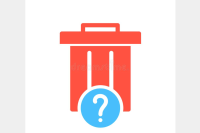

In [7]:
# Return table item
gis.content.get(table_item)

An idea, is to have this table showcased for your users to view and see.  

As a system admin, we have this item on our home page, shared with the Organisation.

Knowing that there is an item shared with the organisation that lists out stale items changes the behaviour of your users to keep on top of cleaning up their own clutter.  

No-one wants to make it onto the name and shame list!

## Notifying Users

There are various ways you can notify your users.  
- Send them an email
- Make a comment on their item
- Push a notification to them in the portal
- Push a message to another service such as Slack or a private Microsoft Teams message (via Microsoft Automate)

For this notebook, we are taking the approach of notifying the item owner through:
- commenting on the item (unless it is shared public/everyone)
- this sends them an email notification about the comment
- make sure we only send them one comment per item to avoid spamming them every time the notebook runs.


**Before running the below cells, make sure you are happy notifying your users about these items**

Optional, but we want to avoid making comments on public items for the world to see.  
The following cell filters the table down further to remove public items.  


In [21]:
# Query for non-public items that have not yet been notified.
# ReminderSent IS NULL is the primary dedup guard — once we write a timestamp
# to that field (in Cell 10), the item drops out of this query permanently.
stale_items = dest_fl.query(
    where="access <> 'public' AND ReminderSent IS NULL"
)
print(f"Items pending notification: {len(stale_items)}")

Items pending notification: 543


Define a function that will check to see if this script has already notified these item owners before.

We only want to make one comment.  If they decide to ignore it, no problem.  We won't mention it again.


In [ ]:
def check_comments(item):
    """Secondary dedup check — guards against the edge case where a previous
    run successfully added a comment but then crashed before writing ReminderSent.
    """
    for c in (item.comments or []):
        if c.get('comment', '').startswith(NOTIFICATION_PREFIX):
            return False  # already notified
    return True

### Step 1 of 2 — Review
Run the cell below to see a full preview of what will be notified. **Nothing is sent at this stage.**

In [ ]:
from collections import defaultdict

# ── Secondary dedup ──────────────────────────────────────────────────────────
# Catches the rare case where a comment was posted on a previous run but the
# notebook crashed before ReminderSent was written back to the table.
already_notified = [
    feature for feature in stale_items.features
    if not check_comments(gis.content.get(feature.get_value('id')))
]
for feature in already_notified:
    stale_items.features.remove(feature)

if already_notified:
    print(f"Secondary dedup removed {len(already_notified)} item(s) that already had a notification comment.\n")

# ── Split into active vs disabled ────────────────────────────────────────────
active_features   = [f for f in stale_items.features if str(f.get_value('disabled')) != '1']
disabled_features = [f for f in stale_items.features if str(f.get_value('disabled')) == '1']

est_seconds = len(active_features) * SLEEP_BETWEEN_COMMENTS
est_mins    = est_seconds // 60
est_secs    = est_seconds % 60

# ── Summary ───────────────────────────────────────────────────────────────────
print(f"{'='*55}")
print(f"  NOTIFICATION PREVIEW — nothing has been sent yet")
print(f"{'='*55}")
print(f"  Total items in queue : {len(stale_items)}")
print(f"  Will notify          : {len(active_features)}  (active owner accounts)")
print(f"  Will skip            : {len(disabled_features)}  (disabled owner accounts)")
print(f"  Estimated run time   : ~{est_mins}m {est_secs}s  (at {SLEEP_BETWEEN_COMMENTS}s per comment)")
print(f"{'='*55}")

# ── Per-owner breakdown ───────────────────────────────────────────────────────
# Shows exactly who will receive a notification and how many items they own.
# Review this list carefully before proceeding to Step 2.
owner_items = defaultdict(list)
for f in active_features:
    email = f.get_value('email') or f.get_value('owner')
    owner_items[email].append(f.get_value('title'))

print(f"\nOwners who will be notified ({len(owner_items)} unique):")
print(f"  {'Owner':<45} {'Items':>5}")
print(f"  {'-'*45}   {'-'*5}")
for email, titles in sorted(owner_items.items(), key=lambda x: -len(x[1])):
    print(f"  {email:<45} {len(titles):>5}")

if disabled_features:
    disabled_owners = defaultdict(list)
    for f in disabled_features:
        email = f.get_value('email') or f.get_value('owner')
        disabled_owners[email].append(f.get_value('title'))
    print(f"\nDisabled accounts (will be skipped — {len(disabled_features)} items across {len(disabled_owners)} owners):")
    print(f"  {'Owner':<45} {'Items':>5}")
    print(f"  {'-'*45}   {'-'*5}")
    for email, titles in sorted(disabled_owners.items(), key=lambda x: -len(x[1])):
        print(f"  {email:<45} {len(titles):>5}")

print(f"\n▶ If you are happy with the above, run the next cell to send notifications.")
print(f"  To abort, do not run the next cell.")


### Step 2 of 2 — Send Notifications
**Only run this cell once you are satisfied with the preview above.**  
This will post a comment on each qualifying item and update `ReminderSent` in the table.

In [ ]:
import time
from datetime import datetime

# ── Step 1: Secondary dedup ───────────────────────────────────────────────────
# Cell 8 already filtered out notified items using ReminderSent IS NULL.
# This step catches the rare edge case where a previous run posted a comment
# successfully but then crashed before writing ReminderSent back to the table.
# For most runs this will find nothing extra to remove.
already_notified = [
    feature for feature in stale_items.features
    if not check_comments(gis.content.get(feature.get_value('id')))
]
for feature in already_notified:
    stale_items.features.remove(feature)

# ── Step 2: Preview — show exactly what will happen before anything is sent ───
# Count active vs disabled owners up front so there are no surprises.
active   = [f for f in stale_items.features if str(f.get_value('disabled')) != '1']
disabled = [f for f in stale_items.features if str(f.get_value('disabled')) == '1']

print(f"Items pending notification : {len(stale_items)}")
print(f"  Will notify              : {len(active)}  (active owner accounts)")
print(f"  Will skip                : {len(disabled)}  (disabled owner accounts)")
print(f"  Estimated time           : ~{len(active) * SLEEP_BETWEEN_COMMENTS}s ({len(active) * SLEEP_BETWEEN_COMMENTS // 60}m {len(active) * SLEEP_BETWEEN_COMMENTS % 60}s)")
print()

if len(active) == 0:
    print("Nothing to notify — either queue is empty or all owners are disabled.")
    raise SystemExit("No notifications sent.")

# ── Step 3: Post a comment on each qualifying item ────────────────────────────
# For each item:
#   - Skip if the owner account is disabled (they can't log in to action it)
#   - Post the notification comment
#   - Mark ReminderSent in memory (written to table in Step 4)
#   - Wait between posts to respect AGOL's rate limit
#   - If rate limited, wait 60s and retry once before giving up
dt_string = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
notified  = []   # features where comment was posted successfully
failed    = []   # item titles where posting failed
skipped   = []   # item titles skipped due to disabled owner

for feature in stale_items.features:
    item       = gis.content.get(feature.get_value('id'))
    size       = round(feature.get_value('size_mb'), 2)
    views_60d  = feature.get_value('numViews60d')
    first_name = feature.get_value('FirstName')
    disabled   = feature.get_value('disabled')

    # Safer disabled check — handles boolean True, integer 1, or string '1'
    if str(disabled) == '1':
        skipped.append(item.title)
        print(f"  ⏭ Skipping '{item.title}' — owner account is disabled.")
        continue

    message = (
        f"{NOTIFICATION_PREFIX}: Hi {first_name}. "
        f"This item is {size} MB and has had {views_60d} views in the last 60 days. "
        f"Please consider whether you still need it and whether it can be deleted "
        f"or archived offline. If you still need it, no action is required — "
        f"it won't be deleted automatically."
    )

    try:
        item.add_comment(message)
        feature.set_value(field_name='ReminderSent', value=dt_string)
        notified.append(feature)
        print(f"  ✓ {item.title}")
    except Exception as e:
        if 'number of comments allowed has been exceeded' in str(e):
            print(f"  ⏸ Rate limit hit — waiting 60s before retrying '{item.title}'...")
            time.sleep(60)
            try:
                item.add_comment(message)
                feature.set_value(field_name='ReminderSent', value=dt_string)
                notified.append(feature)
                print(f"  ✓ {item.title} (after retry)")
            except Exception as e2:
                failed.append(item.title)
                print(f"  ✗ {item.title} — retry failed: {e2}")
        else:
            failed.append(item.title)
            print(f"  ✗ {item.title} — {e}")

    time.sleep(SLEEP_BETWEEN_COMMENTS)

# ── Step 4: Write ReminderSent back to the table ─────────────────────────────
# Only features that were successfully notified are written back.
# Items in 'failed' keep ReminderSent = NULL and will appear in the next run.
if notified:
    from arcgis.features import FeatureSet
    dest_fl.edit_features(updates=FeatureSet(notified))

# ── Summary ───────────────────────────────────────────────────────────────────
print(f"\n{'='*50}")
print(f"  Notified  : {len(notified)}")
print(f"  Skipped   : {len(skipped)}  (disabled owner accounts)")
print(f"  Failed    : {len(failed)}  (will retry automatically next run)")
print(f"{'='*50}")
if failed:
    print(f"\nFailed items:")
    for t in failed: print(f"  - {t}")
if skipped:
    print(f"\nSkipped items (disabled accounts — review with your admin):")
    for t in skipped: print(f"  - {t}")


Items pending after secondary dedup: 543
Notifying 25 of 543 pending items this run.
  (518 will be picked up on the next run.)
  ⏭ Skipping 'SmartDesign Database' — owner account is disabled.
  ✓ Network_Vertices
  ⏭ Skipping 'Boundaries of Territories' — owner account is disabled.
  ✓ MtRainierWebMap_HM_WFL1
  ✓ hotel_stat
  ✓ Hotel Map_WFL1
  ✓ POA_Outside30minCatchment
  ✓ POA_In30minCatchment
  ✓ Enrolment Trends by Postcode _2019_2025_
  ✓ Enrolment Trends by Postcode _2019_2025
  ✓ Residential Postcodes with Enrolments 2019_2025
  ✓ Cowra School Design Data_WFL1
  ✗ NSW_GDA2020_Lambert_POA_TAFE — The number of comments allowed has been exceeded, please wait to post more comments
  ✗ Radial_Flow_Lines_PC_to_TAFE_Enrolments — The number of comments allowed has been exceeded, please wait to post more comments
  ✗ LCAT_P2R_TEST_Export_20250818_HasAttachment — The number of comments allowed has been exceeded, please wait to post more comments
  ⏭ Skipping 'Bush_Fire_Prone_Areas' — ow